In [5]:
%reload_ext autoreload
%autoreload 2

In [6]:
import os

import torch
from ipywidgets import interact

# from qsr_learning.data.data import draw, generate_objects

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Test the `Entity` Class

In [7]:
import math

from PIL import Image
from qsr_learning.entity import Entity

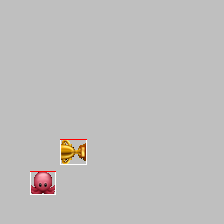

In [8]:
canvas = Image.new("RGBA", (224, 224), (127, 127, 127, 127))
entity1 = Entity(
    name="octopus",
    frame_of_reference="absolute",
    p=(30, 30),
    theta=0 / 360 * 2 * math.pi,
    size=(32, 32),
)
entity1.draw(canvas, add_bbox=True, add_front=True)
entity2 = Entity(
    name="trophy",
    frame_of_reference="absolute",
    p=(60, 60),
    theta=90 / 360 * 2 * math.pi,
    size=(32, 32),
)
entity2.draw(canvas, add_bbox=True, add_front=True)

# Test the Relations

In [4]:
from ipywidgets import interact
from qsr_learning.binary_relation import above, below, left_of, right_of
from qsr_learning.data import DRLDataset

import math
from PIL import Image
from qsr_learning.entity import Entity


@interact(
    frame_of_reference=(0, 1),
    x1=(0, 150),
    y1=(0, 150),
    theta1=(0, 360),
    x2=(0, 150),
    y2=(0, 150),
    theta2=(0, 360),
)
def test_spatial_relations(
    frame_of_reference=0, x1=64, y1=64, theta1=0, x2=128, y2=128, theta2=150
):
    canvas = Image.new("RGBA", (224, 224), (0, 0, 0, 255))
    entity1 = Entity(
        name="octopus",
        frame_of_reference={0: "absolute", 1: "intrinsic"}[frame_of_reference],
        p=(x1, y1),
        theta=theta1 / 360 * 2 * math.pi,
        size=(32, 32),
    )
    entity1.draw(canvas, add_bbox=True, add_front=True)
    entity2 = Entity(
        name="trophy",
        frame_of_reference={0: "absolute", 1: "intrinsic"}[frame_of_reference],
        p=(x2, y2),
        theta=theta2 / 360 * 2 * math.pi,
        size=(32, 32),
    )
    entity2.draw(canvas, add_bbox=True, add_front=True)
    background = Image.new("RGBA", canvas.size, (0, 0, 0))
    image = Image.alpha_composite(background, canvas).convert("RGB")
    display(image)

    for relation in [left_of, right_of, above, below]:
        if relation(entity1, entity2):
            print(entity1.name, relation.__name__, entity2.name)
    for relation in [left_of, right_of, above, below]:
        if relation(entity2, entity1):
            print(entity2.name, relation.__name__, entity1.name)

interactive(children=(IntSlider(value=0, description='frame_of_reference', max=1), IntSlider(value=64, descrip…

In [3]:
from ipywidgets import interact
from qsr_learning.ternary_relation import in_front_of, behind, left_of, right_of

@interact(
    x1=(0, 190),
    y1=(0, 190),
    theta1=(0, 360),
    x2=(0, 150),
    y2=(0, 150),
    theta2=(0, 360),
    x3=(0, 150),
    y3=(0, 150),
    theta3=(0, 360),
)
def test_spatial_relations(
    x1=32, y1=32, theta1=0, x2=64, y2=64, theta2=150, x3=128, y3=128, theta3=150
):
    canvas = Image.new("RGBA", (224, 224), (127, 127, 127, 127))

    entity1 = Entity(
        name="octopus",
        frame_of_reference="relative",
        p=(x1, y1),
        theta=theta1 / 360 * 2 * math.pi,
        size=(32, 32),
    )
    entity1.draw(canvas, add_bbox=False, add_front=False)

    entity2 = Entity(
        name="trophy",
        frame_of_reference="relative",
        p=(x2, y2),
        theta=theta2 / 360 * 2 * math.pi,
        size=(32, 32),
    )
    entity2.draw(canvas, add_bbox=False, add_front=False)

    entity3 = Entity(
        name="lion",
        frame_of_reference="relative",
        p=(x3, y3),
        theta=theta3 / 360 * 2 * math.pi,
        size=(32, 32),
    )
    entity3.draw(canvas, add_bbox=False, add_front=False)

    display(canvas)
    if left_of(entity1, entity2, entity3):
        print(entity1.name, "left_of", entity2.name, "as_seen_from", entity3.name)
    if right_of(entity1, entity2, entity3):
        print(entity1.name, "right_of", entity2.name, "as_seen_from", entity3.name)
    if in_front_of(entity1, entity2, entity3):
        print(entity1.name, "in_front_of", entity2.name, "as_seen_from", entity3.name)
    if behind(entity1, entity2, entity3):
        print(entity1.name, "behind", entity2.name, "as_seen_from", entity3.name)

interactive(children=(IntSlider(value=32, description='x1', max=190), IntSlider(value=32, description='y1', ma…

# Test the Samples

In [ ]:
from qsr_learning.data import draw_entities, generate_entities
from qsr_learning.entity import emoji_names

entities = generate_entities(
    entity_names=emoji_names[:5],
    frame_of_reference="absolute",
    w_range=(32, 32),
    h_range=(32, 32),
)
image = draw_entities(entities, add_bbox=True, add_front=False)
display(image)

# Test the Dataset

In [1]:
import math

import torch
from ipywidgets import interact
from PIL import Image
from torch.utils.data import random_split

from qsr_learning.data import DRLDataset
from qsr_learning.entity import emoji_names

entity_names = [
    "slightly smiling face",
    "nerd face",
    "smiling face with halo",
    "expressionless face",
    "flushed face",
    "face with tears of joy",
    "neutral face",
    "smiling face with heart-eyes",]
relation_names = ["left_of", "right_of", "above", "below"]
dataset = DRLDataset(
    vocab=entity_names + relation_names +['as_seen_from'],
    entity_names=entity_names,
    excluded_entity_names=["slightly smiling face", "nerd face", "expressionless face"],
    relation_names=relation_names,
    excluded_relation_names=["left_of", "right_of", "above", "below"],
    num_entities=5,
    frame_of_reference="absolute",
    w_range=(24, 24),
    h_range=(24, 24),
    theta_range=(0, 2 * math.pi),
    add_bbox=False,
    add_front=False,
    transform=None,
    canvas_size=(128, 128),
    num_samples=1000,
)

In [2]:
@interact(idx=(0, len(dataset) - 1))
def display_sample(idx=0):

    image_t, question_t, answer_t = dataset[idx]
    image = Image.fromarray(
        (255 * (dataset.std.view(-1, 1, 1) * image_t + dataset.mean.view(-1, 1, 1)))
        .permute(1, 2, 0)
        .numpy()
        .astype("uint8")
    )

    question = [dataset.idx2word[idx] for idx in question_t.tolist()]
    answer = bool(answer_t)
    display(image)
    print(question)
    print("Ground truth: ", answer)

interactive(children=(IntSlider(value=0, description='idx', max=999), Output()), _dom_classes=('widget-interac…